In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image ,ImageDraw
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import v2

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


Data Loading

In [ ]:
def download_data(path_dataset):
    data = []
    y_train = []

    for path_dir in sorted(os.listdir(path=path_dataset)):
        path = path_dataset + path_dir + '/'

        for path_image in sorted(os.listdir(path=path)):
            image = Image.open(path + path_image).resize((180, 180))
            image = np.array(image)

            if len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            else:
                image = image[:, :, :3]

            data.append(image.astype(np.uint8))

            if 'Wavy' in path_dir:
                y_train.append(0)
            elif 'Straight' in path_dir:
                y_train.append(1)
            elif 'Dread' in path_dir:
                y_train.append(2)

    return np.array(data), np.array(y_train)

print("✅ Data loading function created!")

✅ Data loading function created!


Load the Dataset

In [ ]:
train_images , y_train =download_data('/content/drive/MyDrive/hair/Train/')
test_images , y_test =download_data('/content/drive/MyDrive/hair/Test/')

print(f'Training samples:{len(train_images)}')
print(f'Testing samples:{len(test_images)}')
print(f'Image Shape:{train_images[0].shape}')
print(f"Label distribution in training:")
print(f"  Wavy (0): {np.sum(y_train == 0)}")
print(f"  Straight (1): {np.sum(y_train == 1)}")
print(f"  Dread (2): {np.sum(y_train == 2)}")

Training samples:1051
Testing samples:210
Image Shape:(180, 180, 3)
Label distribution in training:
  Wavy (0): 280
  Straight (1): 408
  Dread (2): 363


Visualize the Dataset

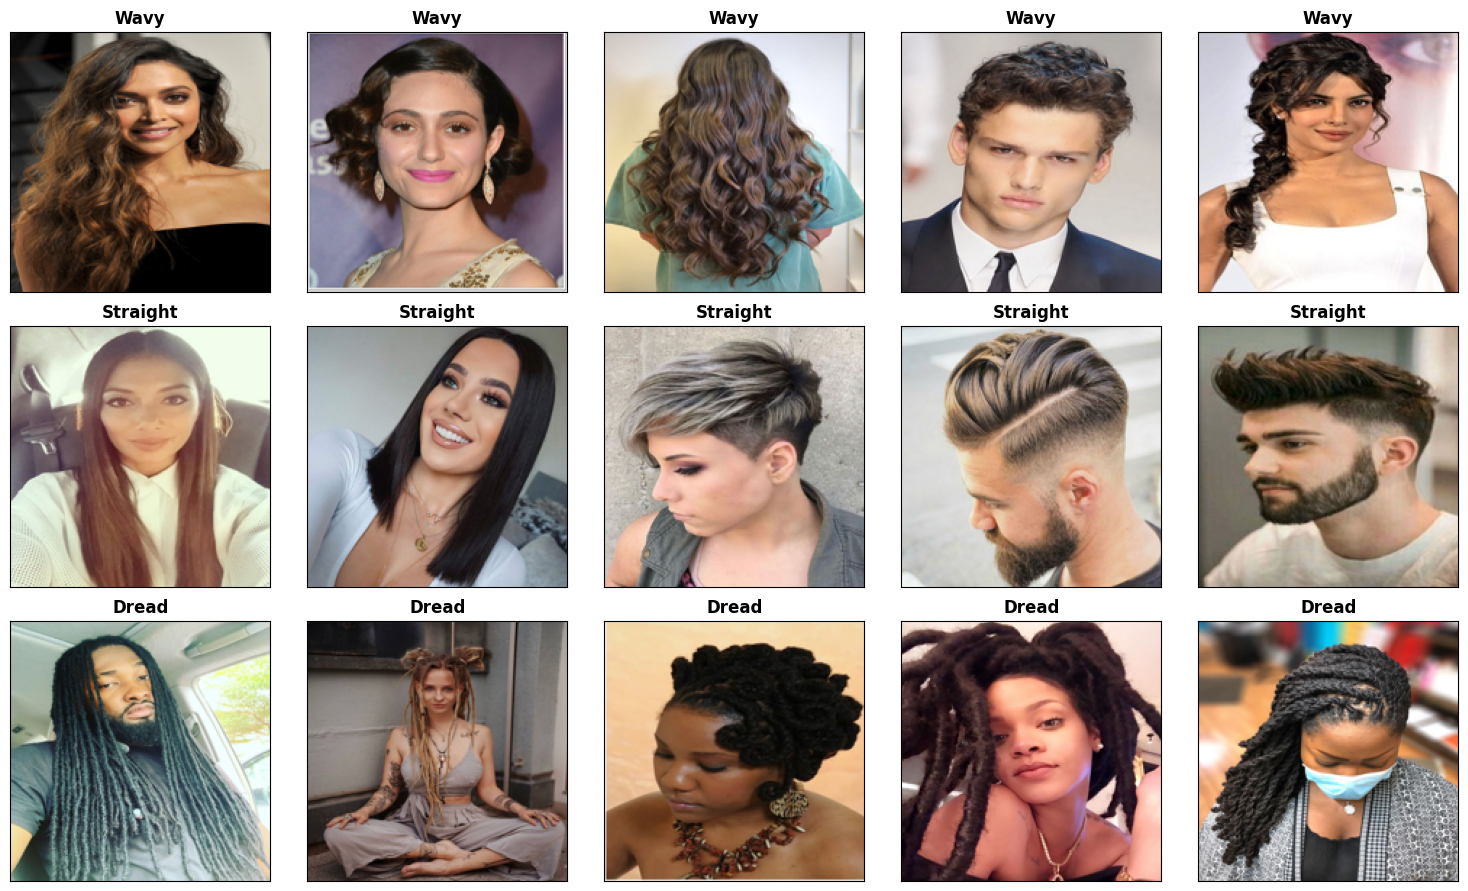

In [ ]:
def plot_images_by_class(images, labels, num_images=5):
    """Display sample images from each class"""
    class_names = {0: 'Wavy', 1: 'Straight', 2: 'Dread'}

    plt.figure(figsize=(15, 9))

    for class_id in range(3):
        # Get images from this class
        class_images = images[labels == class_id][:num_images]

        for i in range(len(class_images)):
            plt.subplot(3, num_images, class_id * num_images + i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(class_images[i])
            plt.title(class_names[class_id], fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Display sample images
plot_images_by_class(train_images, y_train, num_images=5)

Create PyTorch Dataset Class

In [ ]:
class HairDataset(Dataset):
    """
    Custom PyTorch Dataset for Hair images
    """
    def __init__(self, images, labels, transform=None):
        """
        Parameters:
        - images: numpy array of images
        - labels: numpy array of labels (0, 1, or 2)
        - transform: torchvision transforms to apply
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """Return the total number of samples"""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Get a single sample

        Returns:
        - image: transformed image tensor
        - label: integer label (0, 1, or 2)
        """
        # ✅ FIX: Get image and label FIRST
        img = self.images[idx]  # Changed from 'image' to 'img'
        label = self.labels[idx]

        # Convert numpy array to PIL Image (required for transforms)
        img = Image.fromarray(img)

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, label

print("✅ Fixed HairDataset class created!")

✅ Fixed HairDataset class created!


Define Data Transforms

In [ ]:
basic_transform=transforms.Compose([
    transforms.ToTensor(),
])

augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.ToTensor(),
])
print("✅ Transforms created!")
print("📌 Basic transform: Only rescaling [0, 255] → [0, 1]")
print("📌 Augmented transform: Flip + Rotation + Color adjustment + Rescaling")

✅ Transforms created!
📌 Basic transform: Only rescaling [0, 255] → [0, 1]
📌 Augmented transform: Flip + Rotation + Color adjustment + Rescaling


Create DataLoaders

In [ ]:
train_dataset=HairDataset(train_images,y_train,transform=basic_transform)
test_dataset=HairDataset(test_images,y_test,transform=basic_transform)

# Create data loaders
# batch_size=32 means we feed 32 images at a time to the network
train_loader=DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_loader=DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

print("✅ DataLoaders created!")
print(f"📊 Training batches: {len(train_loader)}")
print(f"📊 Test batches: {len(test_loader)}")
print(f"📊 Images per batch: 32")

# Let's verify the data shape
sample_images, sample_labels = next(iter(train_loader))
print(f"\n🔍 Sample batch shape: {sample_images.shape}")  # Should be [32, 3, 180, 180]
print(f"🔍 Sample labels shape: {sample_labels.shape}")    # Should be [32]
print(f"🔍 Pixel value range: [{sample_images.min():.3f}, {sample_images.max():.3f}]")  # Should be [0, 1]

✅ DataLoaders created!
📊 Training batches: 33
📊 Test batches: 7
📊 Images per batch: 32

🔍 Sample batch shape: torch.Size([32, 3, 180, 180])
🔍 Sample labels shape: torch.Size([32])
🔍 Pixel value range: [0.000, 1.000]


Build CNN Model /n

    """
    CNN for Hair Classification
    Architecture: Alternating Conv2D + MaxPooling2D layers (as specified in lab)
    Input: 180x180x3 images (already rescaled to [0,1] by transforms)
    Output: 3 neurons with sigmoid activation
    """

In [ ]:
class HairClassifier(nn.Module):
  def __init__(self,num_classes=3):
      super(HairClassifier, self).__init__()

      # Block 1: Conv2D + ReLU + MaxPooling2D
      self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
      self.relu1=nn.ReLU()
      self.maxpool1=nn.MaxPool2d(kernel_size=2,stride=2)

      # Block 2: Conv2D + ReLU + MaxPooling2D
      self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
      self.relu2=nn.ReLU()
      self.maxpool2=nn.MaxPool2d(kernel_size=2,stride=2)

      # Block 3: Conv2D + ReLU + MaxPooling2D
      self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
      self.relu3=nn.ReLU()
      self.maxpool3=nn.MaxPool2d(kernel_size=2,stride=2)

      #FLATTEN 2D Tensor to 1D Tensor
      self.flatten=nn.Flatten()

      # Fully connected layers
      # After 3 pooling layers: 180 → 90 → 45 → 22
      # Output size: 128 * 22 * 22 = 61,952
      self.fc1=nn.Linear(128 * 22 * 22, 128)
      self.relu4=nn.ReLU()
      self.dropout = nn.Dropout(0.3)

      # Output layer: 3 neurons with SIGMOID (as specified in lab)
      self.fc2 = nn.Linear(128, num_classes)
        # Note: We'll apply sigmoid in the loss function, not here

  def forward(self,x):
    """
        Forward pass
        x: input tensor of shape [batch_size, 3, 180, 180]
     """
    #Block 1
    x=self.conv1(x)
    x=self.relu1(x)
    x=self.maxpool1(x)

    #Block 2
    x=self.conv2(x)
    x=self.relu2(x)
    x=self.maxpool2(x)

    #Block 3
    x=self.conv3(x)
    x=self.relu3(x)
    x=self.maxpool3(x)

    x=self.flatten(x) # [B, 128*22*22] = [B, 61952]

    # Fully connected
    x=self.fc1(x) # [B, 128]
    x=self.relu4(x)
    x=self.dropout(x)
    x=self.fc2(x) # [B, 3]

# Create model and move to device (GPU or CPU)
model = HairClassifier(num_classes=3).to(device)

print("✅ Model created and moved to", device)
print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
print(model)
print("="*60)

# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 Total trainable parameters: {total_params:,}")


✅ Model created and moved to cuda

MODEL ARCHITECTURE
HairClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=61952, out_features=128, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

📊 Total trainable parameters: 8,023,619
